In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import sys
from sklearn.model_selection import train_test_split
import random
import os

%load_ext autoreload
%autoreload 2
import utils
import models
import plots
import Experiments

In [2]:
def set_seed(seed=0):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Control multi-threading randomness
    os.environ["OMP_NUM_THREADS"] = "1"
    os.environ["MKL_NUM_THREADS"] = "1"
    os.environ["OPENBLAS_NUM_THREADS"] = "1"
    os.environ["NUMEXPR_NUM_THREADS"] = "1"

    print(f"Global seed set to {seed}.")

set_seed(0)  # ✅ Set at the start of the notebook

Global seed set to 0.


In [3]:
cfRNA_file = '/Users/irf3irf3/Desktop/offline_workspace/Jessica/R code for bladder vs. healthy models/cfrna_tpm.tsv'
Output_dir = '/Users/irf3irf3/Desktop/offline_workspace/data/tissue_of_origin/cfRNA_Fresh'

cfRNA = pd.read_csv(cfRNA_file, sep='\t', index_col=0)

#cfRNA.rename(columns={'cohort': 'target'}, inplace=True)


print(cfRNA.shape)
display(cfRNA.head())

(168, 56811)


,batch,cohort,A1BG,A1BG.AS1,A1CF,A2M,A2M.AS1,A2ML1,A2ML1.AS1,A2ML1.AS2,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11AP1,ZYG11B,ZYX,ZYXP1,ZZEF1
library,,,,,,,,,,,,,,,,,,,,,
71,1,Healthy,13.758167,0.175150,1.681861,5.963681,0.138247,8.556689,0.043337,0.282723,...,8.874397,3.263274,4.490721,12.532801,0.616501,0.099980,9.101186,31.205180,0.0,10.001192
74,1,Healthy,12.397196,0.714093,7.156571,17.500787,1.717611,6.286029,0.000000,0.766455,...,0.842695,1.932924,12.258831,22.478874,4.034286,0.147232,19.186637,45.338845,0.0,32.288499
75,1,Healthy,2.471901,2.985706,12.814655,45.848567,4.398952,26.231001,0.000000,0.895219,...,11.761095,9.268086,18.636198,4.966974,8.754910,0.059742,13.450622,46.326186,0.0,42.542482
BC004,1,Bladder,32.179657,0.383501,63.792301,25.950843,2.928700,52.693500,0.000000,0.242505,...,31.569267,9.786022,1.823385,18.751395,10.445813,0.000000,16.573738,32.015173,0.0,89.093151
BC007,1,Bladder,25.871792,4.333746,24.445695,78.185451,12.489873,78.143563,0.122776,1.051881,...,21.446064,18.475752,8.192541,13.809481,12.257438,0.660965,30.361498,26.021891,0.0,56.299200


In [4]:
# Replace 'your_file.txt' with the path to your file
protein_gene_file = '/Users/irf3irf3/Desktop/offline_workspace/ResearchCode2_in_transition/Ensemble_unique_ProteinCodig_genes_sorted.bed'

# Read the file with no header
protein_gene_df = pd.read_csv(protein_gene_file, sep='\t', header=None)

# Extract the 4th column (index 3) as a list
protein_gene = protein_gene_df[3].tolist()
protein_gene[:10]

['OR4F5',
 'OR4F29',
 'OR4F16',
 'SAMD11',
 'NOC2L',
 'KLHL17',
 'PLEKHN1',
 'PERM1',
 'HES4',
 'ISG15']

In [5]:
# Ensure 'target' is included in the subset
columns_to_keep = [col for col in protein_gene if col in cfRNA.columns] + ['cohort','batch']

# Subset the DataFrame
cfRNA = cfRNA[columns_to_keep]
print(cfRNA.shape)
display(cfRNA.head())

(168, 18472)


,OR4F5,OR4F29,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,...,BPY2,DAZ1,DAZ2,CDY1B,DAZ3,DAZ4,CDY1,VAMP7,cohort,batch
library,,,,,,,,,,,,,,,,,,,,,
71,0.282031,4.663982,54.823697,27.604289,4.028062,5.256196,0.938382,53.202744,151.733889,9.318976,...,0.000000,0.189140,0.000000,0.064000,0.00000,0.000000,0.835643,16.365287,Healthy,1
74,21.585908,46.193027,22.777548,54.009229,24.735757,25.292861,1.532837,87.310730,33.242778,26.708505,...,0.000000,0.838632,0.014086,0.000000,0.00000,0.000000,0.000000,12.915078,Healthy,1
75,0.021301,62.431836,13.322878,17.928183,9.270124,16.541568,2.252392,25.926609,61.946507,17.668121,...,0.000000,2.151106,0.000000,0.000000,0.00000,0.000000,0.893889,9.386431,Healthy,1
BC004,5.125810,186.740222,65.836392,14.180843,11.083814,13.916225,12.151803,0.000000,29.829223,136.715732,...,21.672311,2.688919,0.024746,5.595970,0.00000,10.782388,5.497099,48.980160,Bladder,1
BC007,0.588153,164.345808,72.703322,38.077752,59.538147,22.755952,9.050222,17.975511,46.517371,118.736870,...,15.187733,41.254721,0.000000,8.785959,2.79451,3.780348,15.391251,26.398007,Bladder,1


In [6]:
cfRNA_allHealthy=cfRNA[(cfRNA['cohort'] == 'Healthy')].copy()

display(cfRNA_allHealthy.head())
print(cfRNA_allHealthy.shape)

,OR4F5,OR4F29,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,...,BPY2,DAZ1,DAZ2,CDY1B,DAZ3,DAZ4,CDY1,VAMP7,cohort,batch
library,,,,,,,,,,,,,,,,,,,,,
71,0.282031,4.663982,54.823697,27.604289,4.028062,5.256196,0.938382,53.202744,151.733889,9.318976,...,0.000000,0.189140,0.000000,0.064000,0.0,0.000000,0.835643,16.365287,Healthy,1
74,21.585908,46.193027,22.777548,54.009229,24.735757,25.292861,1.532837,87.310730,33.242778,26.708505,...,0.000000,0.838632,0.014086,0.000000,0.0,0.000000,0.000000,12.915078,Healthy,1
75,0.021301,62.431836,13.322878,17.928183,9.270124,16.541568,2.252392,25.926609,61.946507,17.668121,...,0.000000,2.151106,0.000000,0.000000,0.0,0.000000,0.893889,9.386431,Healthy,1
ID80,1.846551,118.913054,117.537780,48.877229,67.599293,121.062531,12.923884,12.850718,56.651934,56.776016,...,0.000000,6.356380,0.172021,0.000000,0.0,0.000000,3.565879,8.702600,Healthy,1
Nu-1,14.592436,130.231143,98.564227,53.339023,79.639598,32.698515,11.099656,12.445101,17.570943,101.319449,...,26.860459,21.241356,0.000000,0.083536,0.0,1.043843,19.893952,13.530201,Healthy,1


(52, 18472)


In [7]:
cfRNA_batch1_healthy = cfRNA[~((cfRNA['cohort'] == 'Healthy') & (cfRNA['batch'] == 2))]
cfRNA_batch1_healthy = cfRNA_batch1_healthy.drop(columns=['batch'])
cfRNA_batch2_healthy = cfRNA[~((cfRNA['cohort'] == 'Healthy') & (cfRNA['batch'] == 1))]
cfRNA_batch2_healthy = cfRNA_batch2_healthy.drop(columns=['batch'])
print(cfRNA_batch1_healthy.shape)
print(cfRNA_batch2_healthy.shape)

(144, 18471)
(140, 18471)


In [8]:
display(cfRNA_batch1_healthy.head())

,OR4F5,OR4F29,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,...,PRY,BPY2,DAZ1,DAZ2,CDY1B,DAZ3,DAZ4,CDY1,VAMP7,cohort
library,,,,,,,,,,,,,,,,,,,,,
71,0.282031,4.663982,54.823697,27.604289,4.028062,5.256196,0.938382,53.202744,151.733889,9.318976,...,0.000000,0.000000,0.189140,0.000000,0.064000,0.00000,0.000000,0.835643,16.365287,Healthy
74,21.585908,46.193027,22.777548,54.009229,24.735757,25.292861,1.532837,87.310730,33.242778,26.708505,...,0.000000,0.000000,0.838632,0.014086,0.000000,0.00000,0.000000,0.000000,12.915078,Healthy
75,0.021301,62.431836,13.322878,17.928183,9.270124,16.541568,2.252392,25.926609,61.946507,17.668121,...,0.000000,0.000000,2.151106,0.000000,0.000000,0.00000,0.000000,0.893889,9.386431,Healthy
BC004,5.125810,186.740222,65.836392,14.180843,11.083814,13.916225,12.151803,0.000000,29.829223,136.715732,...,0.000000,21.672311,2.688919,0.024746,5.595970,0.00000,10.782388,5.497099,48.980160,Bladder
BC007,0.588153,164.345808,72.703322,38.077752,59.538147,22.755952,9.050222,17.975511,46.517371,118.736870,...,4.774639,15.187733,41.254721,0.000000,8.785959,2.79451,3.780348,15.391251,26.398007,Bladder


In [9]:
def get_most_variable_genes(df, target_col='cohort', n_genes=10):
    """
    Get a DataFrame containing the most variable genes and the target column.

    Parameters:
    - df: DataFrame where genes are columns and samples are rows, except for the 'target' column.
    - target_col: Name of the column containing the class labels. Default is 'target'.
    - n_genes: Number of top variable genes to include. Default is 10.

    Returns:
    - A DataFrame containing the target column and the most variable genes.
    """
    # Exclude the target column to calculate variance only for genes
    gene_df = df.drop(columns=[target_col])
    
    # Calculate the variance for each gene
    variances = gene_df.var()
    
    # Identify the most variable genes
    most_variable_genes = variances.sort_values(ascending=False).head(n_genes).index.tolist()
    
    # Create a new DataFrame with the target column and the most variable genes
    result_df = df[[target_col] + most_variable_genes]
    
    return result_df

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os

def plot_pca(df, title, target_col='cohort', n_components=2, x_lim=None, y_lim=None, z_lim=None, color_map=None,label_point=False,legend_class_tittle='Class'):
    """
    Plot PCA of gene expression data by sample type.

    Parameters:
    - df: DataFrame where one column is the target (class labels) and others are features.
    - title: Title for the PCA plot.
    - target_col: Name of the column containing class labels. Default is 'target'.
    - n_components: Number of principal components to plot (2 or 3).
    - x_lim: Tuple (min, max) for x-axis limits. Default is None, showing the full range.
    - y_lim: Tuple (min, max) for y-axis limits. Default is None, showing the full range.
    - z_lim: Tuple (min, max) for z-axis limits if n_components=3. Default is None.
    - color_map: Optional dictionary mapping class names to colors.
    """
    # Dynamically separate target and features
    target = df[target_col].values
    features = df.drop(columns=[target_col]).values  # Drop the target column to get features

    # Log transformation
    features_log_transformed = np.log2(features.astype(float) + 1)

    # Scaling
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_log_transformed)

    # PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(features_scaled)

    # Plotting the PCA results with group labels
    if n_components == 2:
        plt.figure(figsize=(10, 8))
        for group in np.unique(target):
            idx = target == group
            color = color_map[group] if color_map and group in color_map else None
            plt.scatter(pca_result[idx, 0], pca_result[idx, 1], label=group, s=100, color=color)

        if label_point:
            # Label all points with their original indices
            for x, y, label in zip(pca_result[:, 0], pca_result[:, 1], df.index):
                plt.text(x, y, str(label), fontsize=8, ha='right', va='bottom', color='black')

        plt.xlabel('PC1')
        plt.ylabel('PC2')
    elif n_components == 3:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        for group in np.unique(target):
            idx = target == group
            color = color_map[group] if color_map and group in color_map else None
            ax.scatter(pca_result[idx, 0], pca_result[idx, 1], pca_result[idx, 2], label=group, s=100, color=color)
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')

    # Set axis limits if provided
    if n_components == 2:
        if x_lim is not None:
            plt.xlim(x_lim)
        if y_lim is not None:
            plt.ylim(y_lim)
    elif n_components == 3:
        if x_lim is not None:
            ax.set_xlim(x_lim)
        if y_lim is not None:
            ax.set_ylim(y_lim)
        if z_lim is not None:
            ax.set_zlim(z_lim)

   # plt.title(title)
    plt.legend(title=legend_class_tittle)


    cfRNA_PCA_dir = Output_dir +"/cfRNA_PCA"  # Path to the new directory

    # Create the directory if it does not exist
    os.makedirs(cfRNA_PCA_dir, exist_ok=True)
    plot_filename = cfRNA_PCA_dir+'/'+legend_class_tittle+"_"+title+"_label_point_"+str(label_point)+".png"
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')


    plt.show()

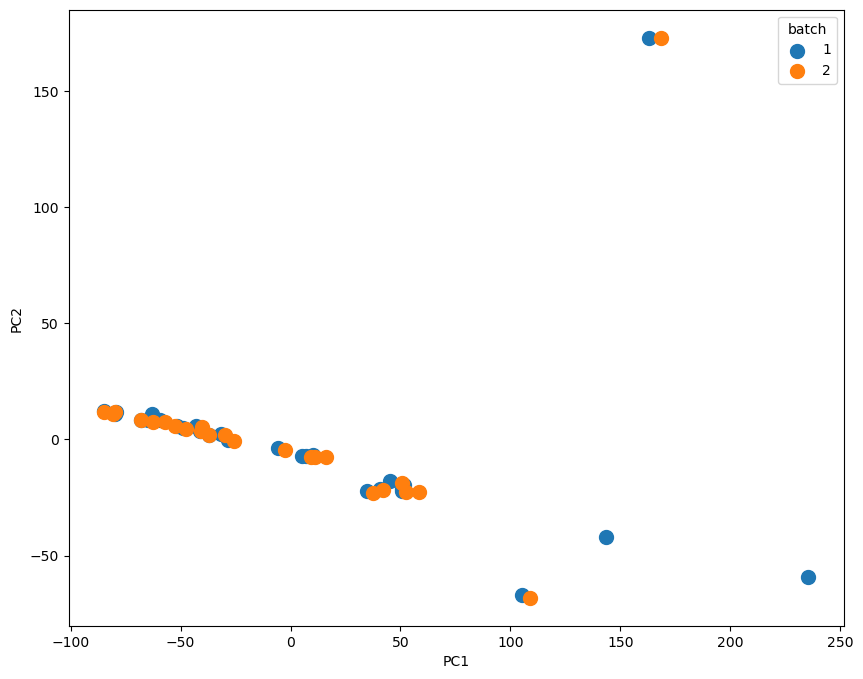

In [11]:
plot_pca(cfRNA_allHealthy.drop(['cohort'],axis=1), 'All genes',target_col='batch',legend_class_tittle='batch')

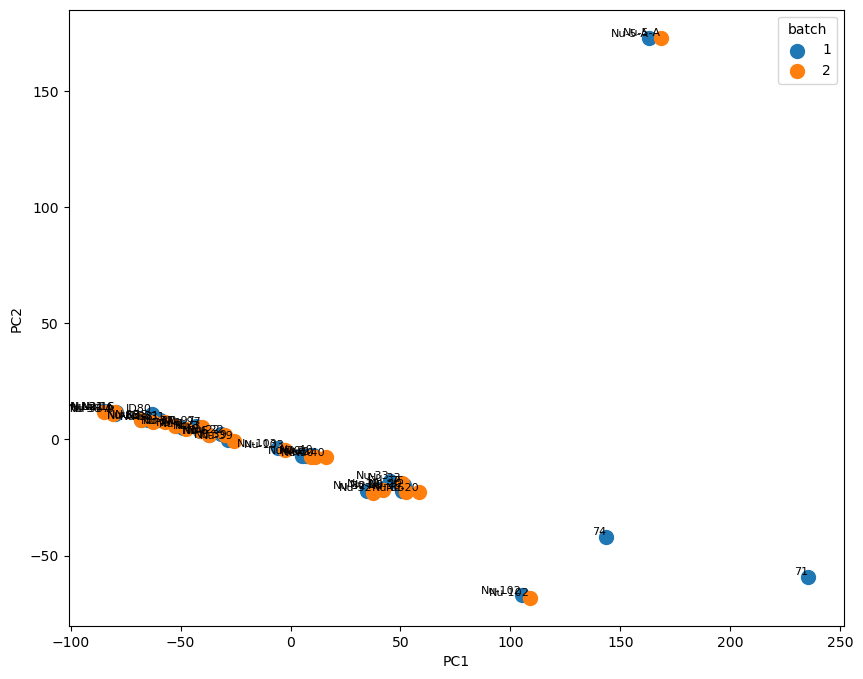

In [12]:
plot_pca(cfRNA_allHealthy.drop(['cohort'],axis=1), 'All genes',target_col='batch',legend_class_tittle='batch', label_point=True)

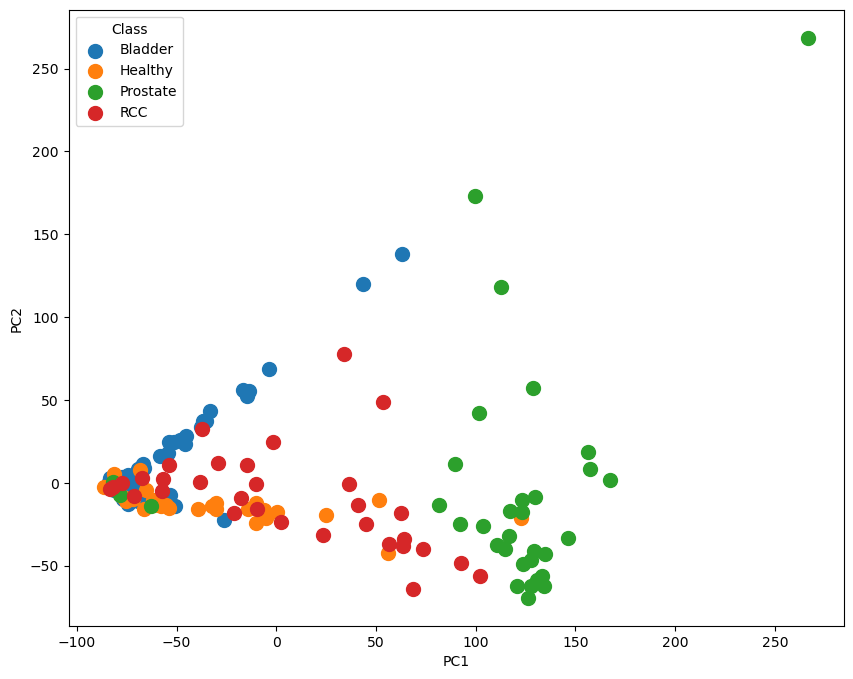

In [13]:
plot_pca(cfRNA_batch1_healthy,  'All genes')

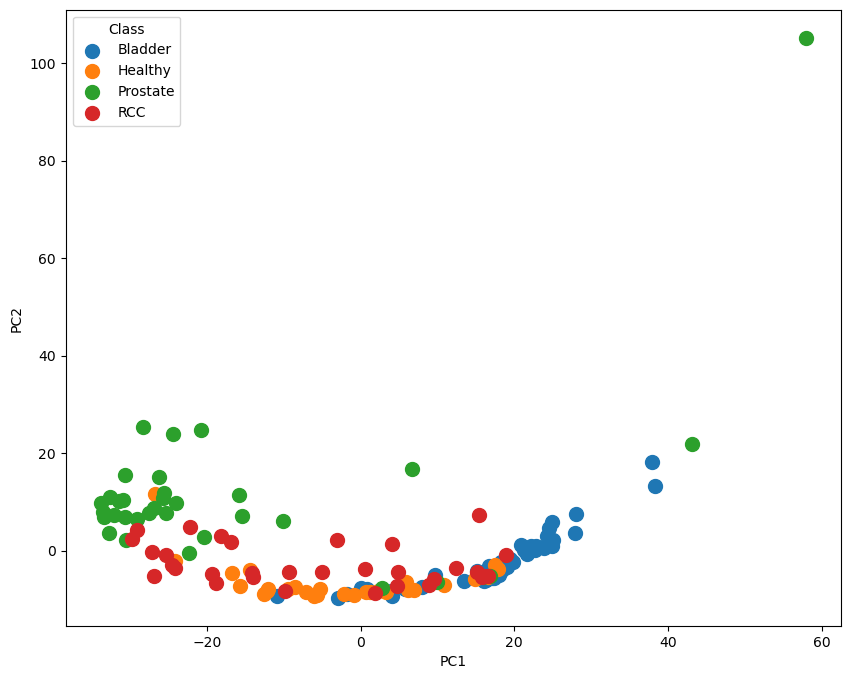

In [14]:
plot_pca(get_most_variable_genes(cfRNA_batch1_healthy,n_genes=1000),  'top1000')

In [15]:
def log_transform(df, target_column='cohort'):
    """
    Log-transforms and standardizes features, excluding the target column.
    """
    # Separate features and target
    features = df.drop(columns=[target_column])
    target = df[target_column]

    # Log transformation
    log_features = features.applymap(lambda x: np.log2(x + 1))



    # Convert back to DataFrame
    logged_df = pd.DataFrame(log_features, columns=features.columns, index=df.index)

    # Add the target back
    logged_df[target_column] = target

    return logged_df

In [16]:
cfRNA_batch1_healthy_logTransformed = log_transform(cfRNA_batch1_healthy)
cfRNA_batch2_healthy_logTransformed = log_transform(cfRNA_batch2_healthy)

In [17]:
cfRNA_batch1_healthy_logTransformed.head()

,OR4F5,OR4F29,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,...,PRY,BPY2,DAZ1,DAZ2,CDY1B,DAZ3,DAZ4,CDY1,VAMP7,cohort
library,,,,,,,,,,,,,,,,,,,,,
71,0.358431,2.501817,5.802806,4.838160,2.330002,2.645286,0.954853,5.760294,7.254876,3.367228,...,0.000000,0.000000,0.249919,0.000000,0.089498,0.000000,0.000000,0.876286,4.118134,Healthy
74,4.497351,5.560502,4.571528,5.781602,4.685702,4.716599,1.340754,6.464517,5.097728,4.792257,...,0.000000,0.000000,0.878633,0.020180,0.000000,0.000000,0.000000,0.000000,3.798577,Healthy
75,0.030408,5.987135,3.840250,4.242464,3.360382,4.132706,1.701501,4.750961,5.976054,4.222505,...,0.000000,0.000000,1.655858,0.000000,0.000000,0.000000,0.000000,0.921352,3.376628,Healthy
BC004,2.614901,7.552594,6.062562,3.924180,3.595004,3.898811,3.717189,0.000000,4.946227,7.105550,...,0.000000,4.502860,1.883198,0.035266,2.721585,0.000000,3.558560,2.699796,5.643284,Bladder
BC007,0.667350,7.369343,6.203658,5.288276,5.919773,4.570217,3.329155,4.246067,5.570383,6.903724,...,2.529731,4.016829,5.401041,0.000000,3.290713,1.923914,2.257116,4.034854,4.775999,Bladder


In [18]:
cfRNA_batch1_healthy_logTransformed_mostvariableGenes=get_most_variable_genes(cfRNA_batch1_healthy_logTransformed ,n_genes=1000)

In [19]:
def stratified_train_test_split(df, test_size=0.3, random_state=0):
    # Assuming the target column is named 'Target'
    X = df.drop(columns=['cohort'])  # Features
    y = df['cohort']  # Target
    
    # Perform stratified train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Combine X and y back into DataFrames for train and test sets
    train_df = X_train.copy()
    train_df['cohort'] = y_train
    
    test_df = X_test.copy()
    test_df['cohort'] = y_test
    
    return train_df, test_df

In [20]:
TEST_SIZE = 0.3

cfRNA_batch1_healthy_logTransformed_mostvariableGenes_train, cfRNA_batch1_healthy_logTransformed_mostvariableGenes_test = stratified_train_test_split(cfRNA_batch1_healthy_logTransformed_mostvariableGenes, test_size=TEST_SIZE)



In [21]:
param_grid_log_reg = [
    {
        'penalty': ['l2'],         
        'C': [0.001, 0.01, 0.1, 1],  # ✅ Reduced C range
        'solver': ['lbfgs'],       
        'max_iter': [5000]
    },
    {
        'penalty': ['l1', 'l2'],   
        'C': [0.001, 0.01, 0.1, 1],  # ✅ Reduced C range
        'solver': ['liblinear'],   # ❌ Removed 'saga' for small data
        'max_iter': [5000]
    },
    {
        'penalty': ['elasticnet'],  
        'C': [0.001, 0.01, 0.1, 1],  # ✅ Reduced C range
        'solver': ['saga'],         
        'max_iter': [5000],
        'l1_ratio': [0.1, 0.2, 0.3]  # ✅ Reduced l1_ratio for better stability
    }
]

param_grid_rf = [{
    'n_estimators': [100, 500, 1000, 5000],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}]

param_grid_svm = [{
    'C': [0.01, 0.1, 1, 10, 100],  # Small to large values to balance underfitting/overfitting
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Default + specific values
    'kernel': ['rbf','linear', 'poly'],
    'probability': [True]  # Ensure probability estimation is enabled
}]

MODEL_SETUP = {'LogReg': [LogisticRegression,param_grid_log_reg], 'RF': [RandomForestClassifier, param_grid_rf], 'SVM': [SVC, param_grid_svm]}


In [22]:
def E2E(train_data, test_data, MODEL_SETUP):
    Train_test_summary = dict() 
    LOOCV_summary = dict()
    feature = 'cfRNA'
    for key in MODEL_SETUP:
        #train test models
        print('\n\n⏳ running train/test')
        tmp_trained_model=  models.train_model(
                                        train_data, 
                                        "cohort", 
                                        MODEL_SETUP[key][0], 
                                        MODEL_SETUP[key][1], 
                                    
                                    )

        predict_folder_path = Output_dir+'/'+feature+'_'+key
        os.makedirs(predict_folder_path, exist_ok=True)
        _, temp_auc = models.predict_model(tmp_trained_model, test_data, plot_cm=True, plot_roc=True, save_figures_path=predict_folder_path)
        
        
        Train_test_summary[feature+'_'+key+'_auc'] = temp_auc
         #LOOCV models
        print('\n\n⏳ running LOOCV')

        LOOCV_folder_path = Output_dir+'/'+feature+'_'+key+'_LOOCV'
        os.makedirs(LOOCV_folder_path, exist_ok=True)
        temp_LOOCV_model, temp_loocv_auc, oof_df = models.train_model_loocv(train_data, test_data, "cohort", MODEL_SETUP[key][0], MODEL_SETUP[key][1], save_figures_path=LOOCV_folder_path) ##🚀 need to use full data before final run
        
        LOOCV_summary[feature+'_'+key+'_LOOCV_auc'] =   temp_loocv_auc 

    plots.plot_auc_heatmap(Train_test_summary, save_figure_path=Output_dir+"/cfRNA_Train_test_summary.png")
    plots.plot_auc_heatmap(LOOCV_summary, save_figure_path=Output_dir+"/cfRNA_LOOCV_summary.png")
    

In [23]:
E2E(cfRNA_batch1_healthy_logTransformed_mostvariableGenes_train, cfRNA_batch1_healthy_logTransformed_mostvariableGenes_test,MODEL_SETUP)



⏳ running train/test
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best hyperparameters found: {'model__C': 1, 'model__l1_ratio': 0.1, 'model__max_iter': 5000, 'model__penalty': 'elasticnet', 'model__solver': 'saga'}


⏳ running LOOCV

🔍 Performing Grid Search with k-Fold CV to find best hyperparameters (on train data only)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

✅ Best hyperparameters found: {'model__C': 1, 'model__l1_ratio': 0.1, 'model__max_iter': 5000, 'model__penalty': 'elasticnet', 'model__solver': 'saga'}

🎯 Running LOOCV with the best hyperparameters on (train + test) data...


KeyboardInterrupt: 

<Figure size 1600x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

IOStream.flush timed out
